## Minimum Spectral Entropy Demonstration (Phase and Delay)

This notebook demonstrates a method for controlling stochastic delay and phase noise in $H(\nu,t)e^{i(\phi_t+\epsilon_t \nu)}$, where $H(\nu,t)$ is the dynamic frequency response determined by dynamic cyclic spectroscopy, $\phi_t$ and $\epsilon_t$ are the unknown degenerate phase and delay at time $t$.

The method is based on minimizing the spectral entropy in $h(\tau,\omega)$ by varying $\phi_t$ and $\epsilon_t$.

In [1]:
from scipy.fft import rfft, fft, fftshift, ifft, fftn, ifftn
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import psrchive

def freq2time(hf, axis=0):
    return ifft(hf, axis=axis, norm="ortho")

def time2freq(ht, axis=0):
    return fft(ht, axis=axis, norm="ortho")

## Spectral Entropy

Defined as $$U = - \sum_j \sum_k p_{jk} \log_2 p_{jk},$$
where $p_{jk}$ is the fractional power spectral density,

\begin{equation}
p_{jk} = P_{jk} \Sigma_P^{-1},
\end{equation}

$P_{jk} = | h^\prime(\tau_j;\omega_k) |^2$ is the power at a
given delay and Doppler shift, and

\begin{equation}
\Sigma_P =  \sum_j \sum_k P_{jk}
\end{equation}

is the total power summed over all delays and Doppler shifts, which remains constant
as the values of $\phi_t$ and $\epsilon_t$ are varied.

See https://www.overleaf.com/read/mjqhtxmtpmmd#19ec75 for derivation of the partial derivatives $dU/d\phi_t$ and $dU/d\epsilon_t$.

In [2]:
def spectral_entropy_grad(alpha, h_time_freq):
    """
    Calculates the total spectral entropy of the time-to-Doppler forward Fourier transform
    and freq-to-delay inverse Fourier transform of the input h_time_freq after mupltiplying each row/time (except the first) by phi
    and shifting each row/time by delay epsilon

    Args:
    alpha: A 1D array of (Ntime - 1) real-valued phase shifts, in radians,
        and (Ntime - 1) real-valued delays, in radians per cycle, to be applied to each row except the first
    h_time_freq: the dynamic frequency response, a 2D array of Ntime * Nfreq complex-values

    Returns:
    The spectral entropy and its gradient with respect to the phase shifts
    """

    Ntime, Nchan = h_time_freq.shape
    
    phs = np.zeros(Ntime)
    eps = np.zeros(Ntime)

    phs[1:] = alpha[0:Ntime-1]
    eps[1:] = alpha[Ntime-1:]

    nus = np.fft.fftfreq(Nchan)
    h_time_freq_prime = h_time_freq * np.exp(1j * np.outer(eps, nus))
    dh_time_freq_prime_deps_oni = np.multiply(h_time_freq_prime, nus[np.newaxis, :])

    h_time_delay_prime = ifft(h_time_freq_prime, axis=1, norm="ortho")
    dh_time_delay_prime_deps_oni = ifft(dh_time_freq_prime_deps_oni, axis=1, norm="ortho")

    phasors = np.exp(1.j * phs)
    h_time_delay_prime = np.multiply(h_time_delay_prime, phasors[:, np.newaxis])
    dh_time_delay_prime_deps_oni = np.multiply(dh_time_delay_prime_deps_oni, phasors[:, np.newaxis])
    
    h_doppler_delay_prime = fft(h_time_delay_prime, axis=0, norm="ortho")
    
    power_spectrum = np.abs(h_doppler_delay_prime)**2
    
    total_power = np.sum(power_spectrum)
    power_spectrum /= total_power
    log_power_spectrum = np.log2(power_spectrum + 1e-16)
    entropy = -np.sum(power_spectrum * log_power_spectrum)

    weighted_ifft = fft((1.+log_power_spectrum)*np.conj(h_doppler_delay_prime), axis=0, norm="ortho")

    # partial derivatives with respect to phi_l
    gradient_phs = 2.0/total_power * np.sum( np.imag( weighted_ifft*h_time_delay_prime ), axis=1)
    grad_phs_power = np.sum(gradient_phs**2)

    # partial derivatives with respect to epsilon_l
    gradient_eps = 2.0/total_power * np.sum( np.imag( weighted_ifft*dh_time_delay_prime_deps_oni ), axis=1)    
    grad_eps_power = np.sum(gradient_eps**2)

    rms = np.sqrt(np.sum(phs**2) / (Ntime-1))
    print (f"rms={rms:.4g} rad; S={entropy} grad power phs={grad_phs_power:.4} eps={grad_eps_power:.4}")

    return entropy, np.concatenate((gradient_phs[1:],gradient_eps[1:]))

def spectral_entropy(h_time_freq):
    """
    Calculates the total spectral entropy of the time-to-Doppler forward Fourier transform 
    of the input h_time_delay

    Args:
    h_time_freq: the dynamic frequency response, a 2D array of Ntime * Nfreq complex-values

    Returns:
    The spectral entropy
    """
    nsub, nchan = h_time_freq.shape
    alpha = np.zeros(2*(nsub-1))
    entropy, grad = spectral_entropy_grad(alpha,h_time_freq)
    return entropy

## Minimize the spectral entropy using BFGS

In [3]:
from scipy.optimize import minimize

def circular(x):
    x[:] = np.fmod(x, 2.0*np.pi)

def minimize_spectral_entropy(h_time_freq):

    Ntime, Nchan = h_time_freq.shape
    initial_guess = np.zeros(2*(Ntime - 1))

    options = {"maxiter": 1000, "disp": True}

    result = minimize(
        spectral_entropy_grad,
        initial_guess,
        args=(h_time_freq,),
        method="BFGS",
        jac=True,
        callback=circular,
        options=options,
    )

    alpha = result.x
    phs = np.zeros(Ntime)
    eps = np.zeros(Ntime)

    phs[1:] = alpha[0:Ntime-1]
    eps[1:] = alpha[Ntime-1:]

    nus = np.fft.fftfreq(Nchan)
    h_time_freq_prime = h_time_freq * np.exp(1j * np.outer(eps, nus))

    phasors = np.exp(1.j * phs)
    h_time_freq[:,:] = np.multiply(h_time_freq_prime, phasors[:, np.newaxis])

## Astrophysical scattering screen

The file `giant_pulse_filters.fits` contains $H(\nu,t)$ the frequency reponse derived from the baseband voltage data for the giant pulse with the greatest S/N in each 20-second interval containing $t$.  Assuming that the intrinsic giant pulse is a delta function, each giant pulse can be treated as an estimate of the impulse response function, the Fourier transform of which is the frequency response.

In [4]:
import pickle
with open ("reproduce_0/filters_full_0.pkl", "rb") as fh:
    h_time_freq = pickle.load(fh)

ntime, nchan = h_time_freq.shape

dT=1
bw=10
cfreq=350

print(f"\nInitial Spectral Entropy: {spectral_entropy(h_time_freq)}\n")

h_time_delay = ifft(h_time_freq,axis=1,norm="ortho")

rms=0 rad; S=13.664134615626729 grad power phs=2.944e-05 eps=5.821e-06

Initial Spectral Entropy: 13.664134615626729



Average Power: 1.0


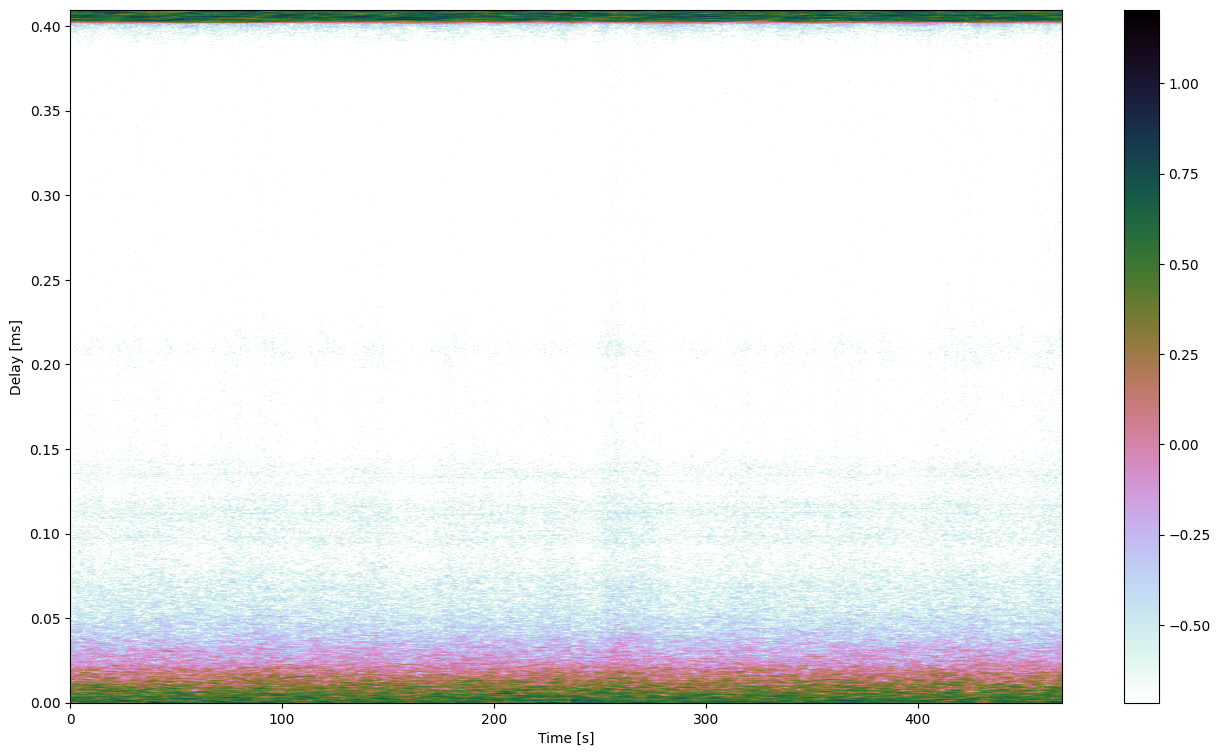

In [5]:
def plot_time_vs_delay (h_time_delay, dT, cfreq, bw):

    ntime, ntap = h_time_delay.shape
    
    power = np.sum(np.abs(h_time_delay)**2) / (ntime * ntap)
    print(f"Average Power: {power}")
 
    plotthis = np.log10(np.abs(h_time_delay) + 1e-2)
    plotmed = np.median(plotthis)

    delta_delay_mus = np.abs(1.0 / bw)
    max_delay_ms = delta_delay_mus * ntap * 1e-3
    extent=[0, dT*ntime, 0, max_delay_ms]
    
    fig, ax = plt.subplots(figsize=(16, 9))
    img = ax.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=plotmed, extent=extent)

    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Delay [ms]")
    fig.colorbar(img)

plot_time_vs_delay(h_time_delay, dT, cfreq, bw)

## Unaligned Wavefield

A Fourier transform along the delay axis yields $H(\nu,t)$, which is then passed to the plot function, which computes and plots the 2D FFT, $h(\tau,\omega)$.  This is expected to look like white Doppler noise because of the large time shifts $\epsilon_t$ that are clearly visible in the above plot.

rms=0 rad; S=13.664134615626729 grad power phs=2.944e-05 eps=5.821e-06
Spectral Entropy: 13.664134615626729


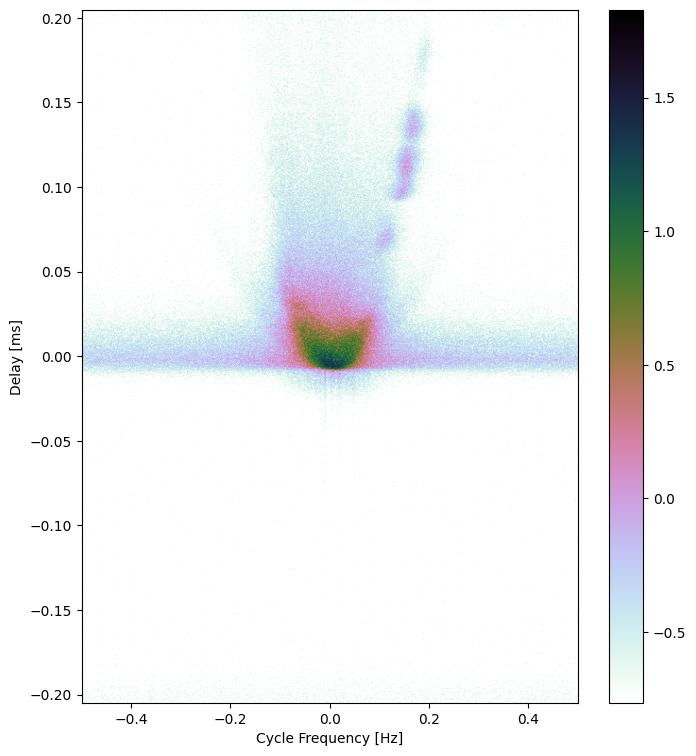

In [6]:
def plot_Doppler_vs_delay (h_time_freq, dT, cfreq, bw):

    print(f"Spectral Entropy: {spectral_entropy(h_time_freq)}")

    h_time_delay = freq2time(h_time_freq, axis=1)
    h_doppler_delay = time2freq(h_time_delay, axis=0)

    ntime, ntap = h_time_delay.shape

    delta_delay_mus = np.abs(1.0 / bw)
    max_delay_ms = delta_delay_mus * ntap * 0.5e-3
    max_Doppler_Hz = .5 / dT
    
    extent=[-max_Doppler_Hz, max_Doppler_Hz, -max_delay_ms, max_delay_ms]
    
    plotthis = np.log10(np.abs(fftshift(h_doppler_delay)) + 1e-2)
    plotmed = np.median(plotthis)
    fig, ax = plt.subplots(figsize=(8, 9))

    ax.set_xlabel("Cycle Frequency [Hz]")
    ax.set_ylabel("Delay [ms]")
    img = ax.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=plotmed, extent=extent)

    fig.colorbar(img)
    
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)

## Coarse alignment using the cross-correlation function.

Each impulse response in $h(\tau,t)$ is aligned to its neighbour and multiplied by a phase term, based on the cross-correlation between them.

In [7]:

def spectral_distance(alpha, z, w):
    """
    Calculates the magnitude of the difference between the two spectra in the two halve of two_spectra
    after mupltiplying the second one by an amplitude, phase, and phase gradient

    Args:
    alpha: A 1D array of 3 values: amplitude, phase, and slope
    two_spectra: the complex-valued spectra to be aligned

    Returns:
    The distance and its gradient with respect to the 3 parameters in alpha
    """

    Nchan = z.size
    phase = alpha[0]
    slope = alpha[1]
    amplitude = 1
    print(f"{amplitude=} {phase=} {slope=}")

    nus = np.fft.fftfreq(Nchan)
    wprime = amplitude * np.exp(1j * phase) * w * np.exp(1j * slope * nus)
    delta = z - wprime

    diff = np.sum(np.abs(delta)**2)

    del_amplitude = wprime / amplitude
    del_phase = 1j * wprime
    del_slope = 1j * nus * wprime

    ddiff_damp = -2 * np.sum ( np.real( np.conj(delta) * del_amplitude ) )
    ddiff_dphs = -2 * np.sum ( np.real( np.conj(delta) * del_phase ) )
    ddiff_dslo = -2 * np.sum ( np.real( np.conj(delta) * del_slope ) )

    print(f"{diff=} del_a={ddiff_damp} del_phi={ddiff_dphs} del_eps={ddiff_dslo}")
    return diff, [ddiff_dphs, ddiff_dslo]

def minimize_difference(z, w):

    Nchan = z.size
    initial_guess = np.zeros(2)

    ccf = fft( np.conj(w) * z )
    ccf_power = np.abs(ccf)**2
    imax = np.argmax(ccf_power)
    ph_max = np.angle(ccf[imax])

    print(f"{imax=} {ph_max=} {Nchan=}")
    
    initial_guess[0] = ph_max

    if imax < Nchan // 2:
        slope = imax
    else:
        slope = imax - Nchan

    initial_guess[1] = slope * 2.0 * np.pi

    options = {"maxiter": 1000, "disp": True, "gtol": 1e-12}
    
    result = minimize(
        spectral_distance,
        initial_guess,
        args=(z,w),
        method="BFGS",
        jac=True,
        # callback=circular,
        options=options,
    )

    alpha = result.x

    phase = alpha[0]
    slope = alpha[1]
    amplitude = 1
    
    nus = np.fft.fftfreq(Nchan)
    w[:] = amplitude * np.exp(1j * phase) * w * np.exp(1j * slope * nus)

def align_to_neighbour(subset):
    nt, ntau = subset.shape
    x = subset[0]
    for idx in range(1,nt):
        y = subset[idx]
        minimize_difference(x,y)
        x = y
        subset[idx,:] = y

In [8]:
align_to_neighbour(h_time_freq)
h_time_delay = ifft(h_time_freq,axis=1,norm="ortho")

imax=0 ph_max=7.170531846063215e-18 Nchan=4096
amplitude=1 phase=7.170531846063215e-18 slope=0.0
diff=512.3657408423855 del_a=512.3657408423848 del_phi=-5.684341886080802e-14 del_eps=13.408708099921503
amplitude=1 phase=4.288854689751811e-15 slope=-1.010000000000005
diff=823.3832116168591 del_a=823.3832116168583 del_phi=-51.44334733331016 del_eps=-621.1879159640292
amplitude=1 phase=9.437052851121673e-17 slope=-0.02056947532414048
diff=512.2262177412823 del_a=512.2262177412815 del_phi=-1.1307546269788133 del_eps=0.15732363058779342
amplitude=1 phase=0.24631490320550184 slope=-0.04164035782725071
diff=743.5978839320011 del_a=743.5978839320001 del_phi=1870.3183905571054 del_eps=0.3959587559351405
amplitude=1 phase=0.00014833607261602967 slope=-0.020582164657657807
diff=512.2261324529256 del_a=512.2261324529244 del_phi=0.007735195369861003 del_eps=0.1573044861411983
amplitude=1 phase=0.00014907740960996764 slope=-0.02082641114362292
diff=512.2261132457243 del_a=512.226113245724 del_phi=-3

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=546.7345898924046 del_a=546.7345898924061 del_phi=1570.4811266731772 del_eps=73.14475835030584
amplitude=1 phase=-0.012238346647069765 slope=0.5135680229890612
diff=382.61916969427955 del_a=382.6191696942808 del_phi=-81.03918692376584 del_eps=-0.06671969729030991
amplitude=1 phase=-0.0018614442271848541 slope=0.5133369948057663
diff=382.198706022996 del_a=382.1987060229969 del_phi=-0.0016433067553141 del_eps=-0.07607847124327805
amplitude=1 phase=-0.0018614342013401365 slope=0.5134798483777027
diff=382.1987006228007 del_a=382.1987006228017 del_phi=1.0525521398463411e-05 del_eps=0.00047396138965827284
amplitude=1 phase=-0.0018614343000479291 slope=0.5134789639248195
diff=382.1987006225911 del_a=382.1987006225921 del_phi=1.0876277656279854e-10 del_eps=-1.1211920281084531e-11
amplitude=1 phase=-0.0018614343000618856 slope=0.5134789639248407
diff=382.1987006225911 del_a=382.19870062259224 del_phi=-0.0 del_eps=-4.440892098500626e-15
Optimization terminated successfully.
         Curren

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=660.5040929484101 del_a=660.5040929484126 del_phi=2.7095348571582107 del_eps=50.30164440011555
amplitude=1 phase=-0.010628504279197242 slope=0.9943451917745936
diff=659.9195241673576 del_a=659.9195241673599 del_phi=2.2376271811140853 del_eps=41.57118521835107
amplitude=1 phase=-0.010625272795794356 slope=0.957995304446176
diff=658.8617621316105 del_a=658.8617621316132 del_phi=0.8948829417073867 del_eps=16.626612945987997
amplitude=1 phase=-0.010623103878947071 slope=0.9337665655789752
diff=658.6603816074119 del_a=658.6603816074143 del_phi=-0.0001788559704891668 del_eps=-0.0035641705818072467
amplitude=1 phase=-0.010623106066825237 slope=0.9337717583636378
diff=658.6603815981586 del_a=658.6603815981609 del_phi=2.1891466417400807e-10 del_eps=1.7175159872095946e-07
amplitude=1 phase=-0.010623106065604236 slope=0.9337717581133569
diff=658.6603815981586 del_a=658.6603815981609 del_phi=2.2808421817899216e-12 del_eps=3.4638958368304884e-14
         Current function value: 658.660382
    

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=436.44645003766476 del_a=436.4464500376644 del_phi=2.05994591668437 del_eps=-63.63890710994674
amplitude=1 phase=-0.0022589862169117222 slope=1.02110938592385
diff=435.93151509246417 del_a=435.9315150924635 del_phi=1.9027521366474787 del_eps=-58.780235721845706
amplitude=1 phase=-0.0022550695445223866 slope=1.0547601002339317
diff=434.28058961693864 del_a=434.28058961693785 del_phi=1.2678229651359771 del_eps=-39.34007914413273
amplitude=1 phase=-0.0022453538043979136 slope=1.1228625182740473
diff=432.9415983583866 del_a=432.9415983583858 del_phi=-0.031990985287603024 del_eps=0.01922958268345365
amplitude=1 phase=-0.0022413150814149995 slope=1.122829387085613
diff=432.94159797533723 del_a=432.94159797533683 del_phi=2.3648114627405903e-05 del_eps=-3.2419848716713773e-06
amplitude=1 phase=-0.0022413181153316335 slope=1.1228293925860668
diff=432.94159797533723 del_a=432.94159797533734 del_phi=-4.773895057041955e-09 del_eps=-5.825562254813121e-10
         Current function value: 432.94

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

amplitude=1 phase=-0.0108108736414701 slope=1.0237075476203779
diff=425.6802661976966 del_a=425.68026619769756 del_phi=7.587613279112077 del_eps=-205.48990293289452
amplitude=1 phase=-0.010427842634861975 slope=1.068905875204587
diff=417.0530770892469 del_a=417.0530770892482 del_phi=6.382357480784208 del_eps=-176.367580131581
amplitude=1 phase=-0.009306038024728406 slope=1.194812916625005
diff=399.9711435339931 del_a=399.9711435339941 del_phi=3.4808488645609543 del_eps=-95.01446255203322
amplitude=1 phase=-0.008007737128595262 slope=1.3418613940151107
diff=393.0027532775201 del_a=393.00275327752144 del_phi=0.005242411842480976 del_eps=0.22305385724756244
amplitude=1 phase=-0.008012504709305587 slope=1.3415167493017242
diff=393.0027148367212 del_a=393.0027148367226 del_phi=-1.4925850479130531e-05 del_eps=-5.129087248478825e-05
amplitude=1 phase=-0.008012501843224742 slope=1.3415168287854136
diff=393.0027148367192 del_a=393.00271483672014 del_phi=6.404185626252001e-08 del_eps=-8.45425951

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=478.45373106327725 del_a=478.45373106327685 del_phi=-0.003375061680223723 del_eps=0.025958004749503605
amplitude=1 phase=-0.008366815054839301 slope=1.2402273409101459
diff=478.45373051398013 del_a=478.4537305139793 del_phi=3.633685780712881e-06 del_eps=-1.6317234150520221e-06
amplitude=1 phase=-0.008366815513259511 slope=1.240227343539756
diff=478.4537305139801 del_a=478.45373051397917 del_phi=-7.237824561912021e-09 del_eps=-3.753219957047804e-11
amplitude=1 phase=-0.008366815512319463 slope=1.2402273435398805
diff=478.45373051398013 del_a=478.4537305139793 del_phi=8.29558643999917e-12 del_eps=1.4084289290394736e-12
amplitude=1 phase=-0.008366815513259511 slope=1.240227343539756
diff=478.4537305139801 del_a=478.45373051397917 del_phi=-7.237824561912021e-09 del_eps=-3.753219957047804e-11
amplitude=1 phase=-0.008366815512789488 slope=1.2402273435398183
diff=478.4537305139802 del_a=478.4537305139797 del_phi=-3.614776034055467e-09 del_eps=-1.7994938872334387e-11
amplitude=1 phase=-0.

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=561.0479118406947 del_a=561.047911840696 del_phi=1.4741977452104038e-06 del_eps=7.298076631911954e-08
amplitude=1 phase=-0.005409973413392623 slope=1.8330005967283856
diff=561.0479118406946 del_a=561.0479118406961 del_phi=1.4743557947838326e-06 del_eps=7.29885374362027e-08
amplitude=1 phase=-0.005409973413402989 slope=1.8330005967283798
diff=561.0479118406946 del_a=561.0479118406955 del_phi=1.4742767753261887e-06 del_eps=7.298457127546953e-08
amplitude=1 phase=-0.00540997341340983 slope=1.833000596728376
diff=561.0479118406946 del_a=561.0479118406959 del_phi=1.4742246285948113e-06 del_eps=7.298197690630559e-08
amplitude=1 phase=-0.005409973413412156 slope=1.833000596728375
diff=561.0479118406947 del_a=561.047911840696 del_phi=1.4742068721318446e-06 del_eps=7.298121573739991e-08
amplitude=1 phase=-0.00540997341340983 slope=1.833000596728376
diff=561.0479118406946 del_a=561.0479118406959 del_phi=1.4742246285948113e-06 del_eps=7.298197690630559e-08
amplitude=1 phase=-0.00540997341341

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=7964.713018556806 del_a=7964.713018556808 del_phi=-7665.1417256554505 del_eps=51.46427339436809
amplitude=1 phase=-0.12785070600851808 slope=-0.12792285645205487
diff=518.2206156367289 del_a=518.2206156367299 del_phi=0.8607307774178441 del_eps=0.6631107649045349
amplitude=1 phase=-0.12797025954240002 slope=-0.12898511137085986
diff=518.2202121556727 del_a=518.2202121556737 del_phi=2.863190437984997e-05 del_eps=-0.00031749004974646056
amplitude=1 phase=-0.12797025977308812 slope=-0.12898460787877475
diff=518.2202121555929 del_a=518.220212155594 del_phi=-2.6210287273897848e-08 del_eps=2.871699766870961e-09
amplitude=1 phase=-0.12797025976970205 slope=-0.1289846078830422
diff=518.2202121555929 del_a=518.2202121555937 del_phi=1.4477308241112041e-12 del_eps=5.329070518200751e-15
         Current function value: 518.220212
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
imax=0 ph_max=-0.1278817287141733 Nchan=4096
amplitude=1 phase=-0.12788172871

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

amplitude=1 phase=-0.12909205603676563 slope=0.16315105198146868
diff=661.1749621715142 del_a=661.1749621715162 del_phi=2.240436064937512e-05 del_eps=0.0004857974400680476
amplitude=1 phase=-0.12909205637021198 slope=0.16315025286918536
diff=661.1749621713202 del_a=661.1749621713224 del_phi=-1.7968702081816446e-09 del_eps=1.8811441293564712e-10
amplitude=1 phase=-0.1290920563699723 slope=0.16315025286886609
diff=661.17496217132 del_a=661.1749621713215 del_phi=2.1316282072803006e-14 del_eps=-1.5987211554602254e-14
Optimization terminated successfully.
         Current function value: 661.174962
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8
imax=0 ph_max=-0.12928397620011484 Nchan=4096
amplitude=1 phase=-0.12928397620011484 slope=0.0
diff=542.9655675648553 del_a=542.9655675648548 del_phi=-1.9895196601282805e-13 del_eps=-145.59575622093305
amplitude=1 phase=-0.12928397620011345 slope=1.0099999999999998
diff=705.8681905118428 del_a=705.86819051184

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=500.06145530697376 del_a=500.06145530697165 del_phi=0.10272530718733819 del_eps=-0.32310466817521544
amplitude=1 phase=-0.13043484255212506 slope=0.5976186165396128
diff=500.06137671576073 del_a=500.0613767157587 del_phi=-0.0008542255088705986 del_eps=0.00013504904372485527
amplitude=1 phase=-0.1304347297688004 slope=0.5976184099474247
diff=500.0613767156989 del_a=500.06137671569695 del_phi=5.9566310355307905e-06 del_eps=1.9413296481474163e-07
amplitude=1 phase=-0.13043473054252577 slope=0.5976184096964702
diff=500.0613767156989 del_a=500.0613767156972 del_phi=-3.7335468050514464e-09 del_eps=-2.038192725706267e-09
         Current function value: 500.061377
         Iterations: 8
         Function evaluations: 14
         Gradient evaluations: 14
imax=0 ph_max=-0.12965815964013033 Nchan=4096
amplitude=1 phase=-0.12965815964013033 slope=0.0
diff=682.1215972775364 del_a=682.1215972775371 del_phi=1.1368683772161603e-13 del_eps=-397.1840538631018
amplitude=1 phase=-0.1296581596401306 

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=643.9165874339403 del_a=643.9165874339399 del_phi=1.7350272472071993e-06 del_eps=-4.5432163897629607e-07
         Current function value: 643.916587
         Iterations: 5
         Function evaluations: 60
         Gradient evaluations: 48
imax=0 ph_max=-0.11507392082925398 Nchan=4096
amplitude=1 phase=-0.11507392082925398 slope=0.0
diff=665.3000654042496 del_a=665.3000654042506 del_phi=2.2737367544323206e-13 del_eps=-511.4341390287284
amplitude=1 phase=-0.11507392082925443 slope=1.0100000000000002
diff=448.7678503744626 del_a=448.76785037446314 del_phi=22.845222885863933 del_eps=87.79975343584908
amplitude=1 phase=-19.613014615567092 slope=1.6053552602793069
diff=2124.8920803177734 del_a=2124.8920803177743 del_phi=-4553.043232206359 del_eps=339.39162734389896
amplitude=1 phase=-7.405704320617121 slope=1.232614030231273
diff=4052.018781310123 del_a=4052.018781310124 del_phi=-6502.875361953193 del_eps=100.60127239837766
amplitude=1 phase=-2.3966842957595187 slope=1.0796672925561406

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=597.7051517163904 del_a=597.7051517163936 del_phi=-4.11311399659553e-05 del_eps=-1.1556556600567092e-07
amplitude=1 phase=-0.11896677706051427 slope=0.9988238321603133
diff=597.7051517163903 del_a=597.7051517163936 del_phi=-4.113114007253671e-05 del_eps=-1.155655606766004e-07
amplitude=1 phase=-0.11896677706051426 slope=0.9988238321603133
diff=597.7051517163904 del_a=597.7051517163936 del_phi=-4.11311399659553e-05 del_eps=-1.1556556600567092e-07
amplitude=1 phase=-0.11896677706051427 slope=0.9988238321603133
diff=597.7051517163903 del_a=597.7051517163936 del_phi=-4.113114007253671e-05 del_eps=-1.155655606766004e-07
amplitude=1 phase=-0.11896677706051426 slope=0.9988238321603133
diff=597.7051517163904 del_a=597.7051517163936 del_phi=-4.11311399659553e-05 del_eps=-1.1556556600567092e-07
amplitude=1 phase=-0.11896677706051427 slope=0.9988238321603133
diff=597.7051517163903 del_a=597.7051517163936 del_phi=-4.113114007253671e-05 del_eps=-1.155655606766004e-07
amplitude=1 phase=-0.11896

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

diff=450.70558191504915 del_a=450.7055819150501 del_phi=-3.147280168036559e-06 del_eps=-5.514736400868969e-08
amplitude=1 phase=-0.11812573551202078 slope=1.089100490747299
diff=450.70558191504927 del_a=450.7055819150498 del_phi=-3.29833726908646e-06 del_eps=-5.778349843055253e-08
amplitude=1 phase=-0.11812573553130512 slope=1.0891004907449455
diff=450.7055819150492 del_a=450.70558191505023 del_phi=-3.4477439712077285e-06 del_eps=-6.039084388120841e-08
amplitude=1 phase=-0.11812573554094728 slope=1.089100490743769
diff=450.70558191504915 del_a=450.70558191504955 del_phi=-3.522447364900927e-06 del_eps=-6.169444377590594e-08
amplitude=1 phase=-0.11812573554416526 slope=1.0891004907433761
diff=450.70558191504915 del_a=450.70558191504944 del_phi=-3.547378859991568e-06 del_eps=-6.212958414408831e-08
amplitude=1 phase=-0.11812573554806828 slope=1.0891004907428998
diff=450.70558191504915 del_a=450.7055819150495 del_phi=-3.5776177043089774e-06 del_eps=-6.265726781862213e-08
amplitude=1 phase=-

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desire

## Coarsely-aligned Impulse Responses

It's reassuring to see temporally persistent features in the impulse responses.

Average Power: 1.0


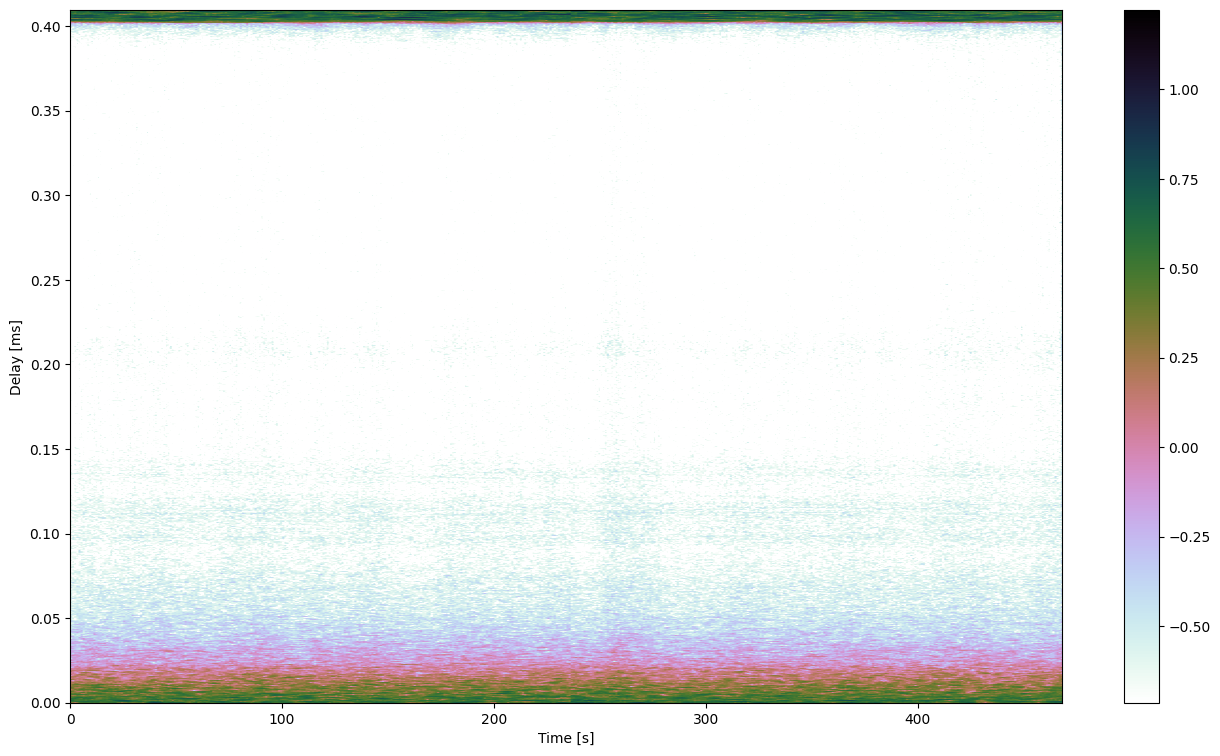

In [9]:
plot_time_vs_delay(h_time_delay, dT, cfreq, bw)

## Individually-aligned Response Wavefield

rms=0 rad; S=13.66843022206901 grad power phs=3.648e-05 eps=4.235e-06
Spectral Entropy: 13.66843022206901


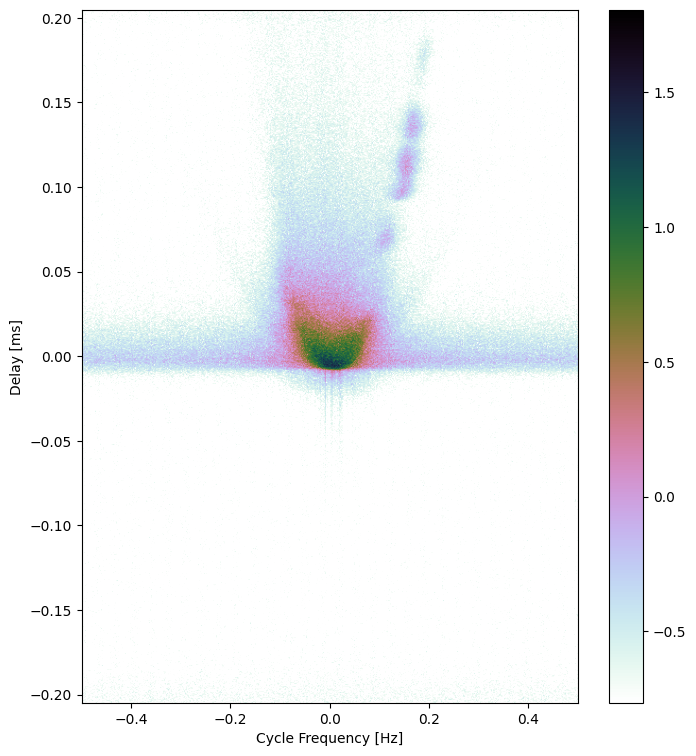

In [10]:
h_time_freq = fft(h_time_delay,axis=1,norm="ortho")
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)

## Perform fine alignment by minimizing the spectral entropy

In [11]:
minimize_spectral_entropy(h_time_freq)

rms=0 rad; S=13.66843022206901 grad power phs=3.648e-05 eps=4.235e-06
rms=0.0002752 rad; S=13.668390956746073 grad power phs=3.583e-05 eps=4.231e-06
rms=0.001376 rad; S=13.668237302623737 grad power phs=3.332e-05 eps=4.218e-06
rms=0.00578 rad; S=13.667677227544354 grad power phs=2.513e-05 eps=4.164e-06
rms=0.01871 rad; S=13.666526412150139 grad power phs=1.787e-05 eps=4.015e-06
rms=0.03255 rad; S=13.666079605320524 grad power phs=3.621e-05 eps=3.872e-06
rms=0.03338 rad; S=13.666041809317848 grad power phs=3.688e-05 eps=3.86e-06
rms=0.03673 rad; S=13.665910208442277 grad power phs=3.996e-05 eps=3.814e-06
rms=0.04151 rad; S=13.665599785521675 grad power phs=3.926e-05 eps=3.733e-06
rms=0.04868 rad; S=13.665063367341055 grad power phs=3.512e-05 eps=3.604e-06
rms=0.06162 rad; S=13.664369704063583 grad power phs=4.267e-05 eps=3.382e-06
rms=0.06473 rad; S=13.664220221520429 grad power phs=5.279e-05 eps=3.319e-06
rms=0.06452 rad; S=13.664131471068934 grad power phs=5.666e-05 eps=3.304e-06
rms=

/home/willem/.local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


## Finely-aligned Wavefield

After fine alignment, an arc appears!  It's at a funny delay and Doppler shift, but it's a start!  The offeset in cycle frequency $\Delta\omega$ could be fixed by a applying a phase gradient along the time axis; i.e. $h^\prime(\tau,t)= h(\tau,t)\exp(i2\pi t\Delta\omega)$

rms=0 rad; S=13.61318622015249 grad power phs=8.363e-08 eps=1.004e-06
Spectral Entropy: 13.61318622015249


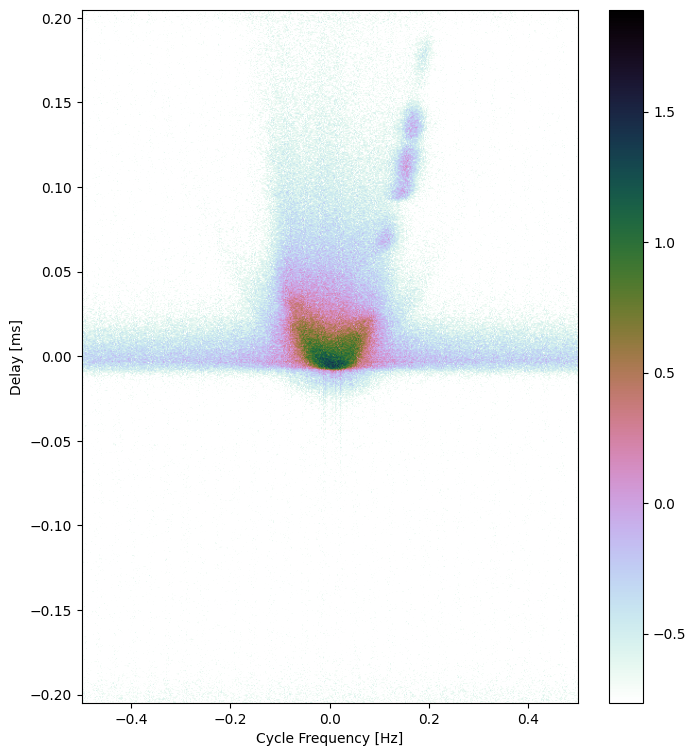

In [12]:
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)

Average Power: 1.0000000000000002


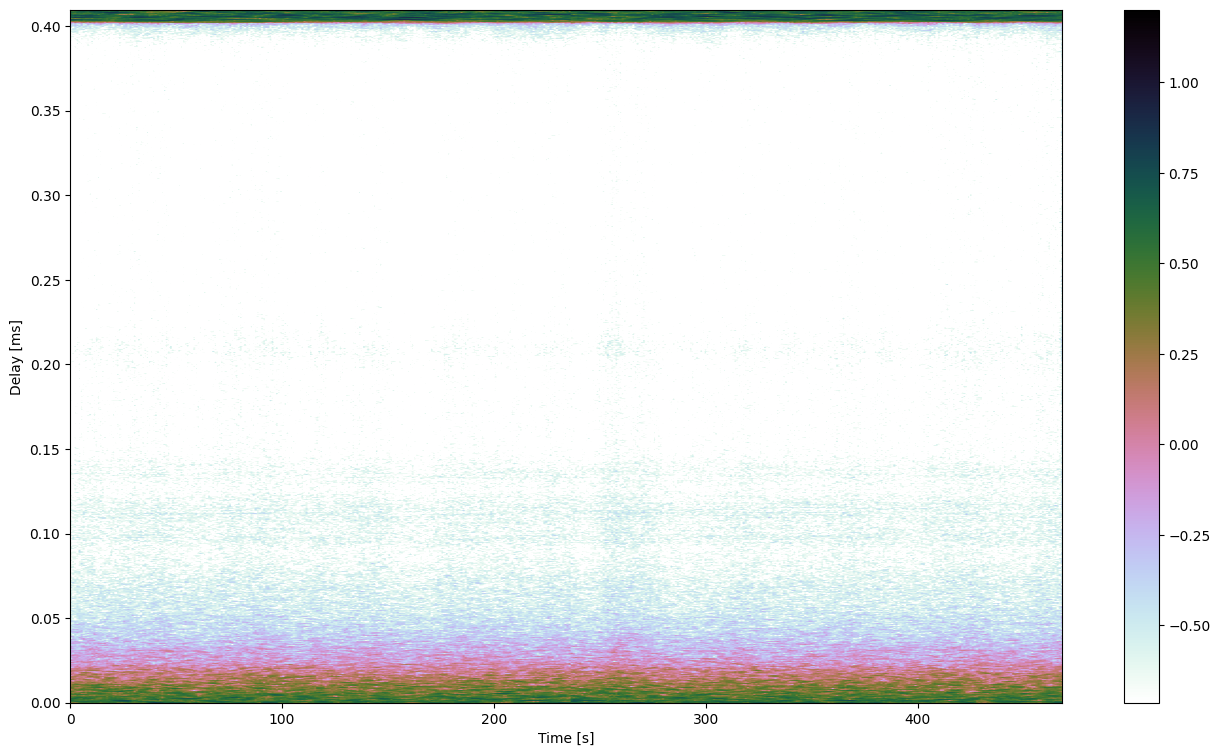

In [13]:
h_time_delay = ifft(h_time_freq,axis=1,norm="ortho")
plot_time_vs_delay(h_time_delay, dT, cfreq, bw)